# Cleaning and EDA
Dataset: Triage accuracy and causes of mistriage using the Korean Triage and Acuity Scale

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

Conclusion this study came to: 
There was highly agreement between the KTAS scores determined by emergency nurses and those determined by experts. The main cause of mistriage was misapplication of the pain scale to the KTAS algorithm.

In [4]:
df_raw = pd.read_excel('data/raw.xls')
df_codes = pd.read_excel('data/codes.xls')

## Understanding the Features

Going through feature by feature, graphing distribution, and cleaning raw data

In [163]:
df_raw.head()

,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,...,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage
0,2,2,71,3,3,2,right ocular pain,1,1,2.0,...,36.6,100,2,Corneal abrasion,1,4,2,86,5.00,1
1,1,1,56,12,3,2,right forearm burn,1,1,2.0,...,36.5,NaN,4,"Burn of hand, firts degree dorsum",1,5,4,64,3.95,1
2,2,1,68,8,2,2,"arm pain, Lt",1,1,2.0,...,36.6,98,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,1.00,1
3,1,2,71,8,1,1,ascites tapping,1,1,3.0,...,36.5,NaN,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,9.83,1
4,1,2,58,4,3,1,"distension, abd",1,1,3.0,...,36.5,NaN,4,Ascites,1,5,8,109,6.60,1


In [164]:
# These codes describe the features 
df_codes

,Group,1: Local ED / 2: Regional ED
0,Sex,1: Female / 2: Male
1,Age,Age (Years)
2,Patients number per hour,Patients number/hous
3,Arrival mode,1: Walking / 2: 119 use / 3: Private car / 4: ...
4,Injury,1: Non-injury / 2: Injury
5,Mental,1: Alert / 2: Verval response / 3: Pain respon...
6,Pain,1: Pain / 2: Non-pain
7,NRS_pain,Numeric rating scales of pain
8,SBP,Systolid blood pressure
9,DBP,Diastolic blood pressure


In [143]:
# Looks like there are some nans in the NRS_pain and Saturation features
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 24 columns):
Group                       1267 non-null int64
Sex                         1267 non-null int64
Age                         1267 non-null int64
Patients number per hour    1267 non-null int64
Arrival mode                1267 non-null int64
Injury                      1267 non-null int64
Chief_complain              1267 non-null object
Mental                      1267 non-null int64
Pain                        1267 non-null int64
NRS_pain                    711 non-null float64
SBP                         1267 non-null object
DBP                         1267 non-null object
HR                          1267 non-null object
RR                          1267 non-null object
BT                          1267 non-null object
Saturation                  579 non-null object
KTAS_RN                     1267 non-null int64
Diagnosis in ED             1265 non-null object
Disposition          

**Group** Refers to the hospital where this data was collected (2 hospitals were used)
Changing to **hospital** 0: local hospital, 1: Regional hospital

0: Local ED / 1: Regional ED

In [165]:
df_clean = df_raw.rename(columns = {'Group':'hospital'})
df_clean['hospital'] = df_clean['hospital'].replace({1:0, 2:1})

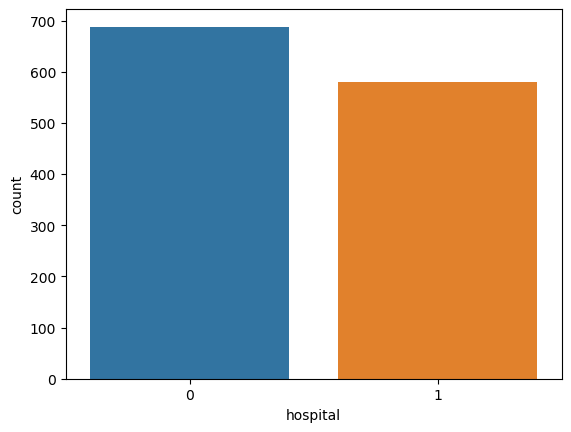

In [166]:
sns.countplot(df_clean['hospital']);

**Sex** Refers to female/male. Changing to **sex**

0: Female / 1: Male

In [167]:
df_clean = df_clean.rename(columns = {'Sex':'sex'})
df_clean['sex'] = df_clean['sex'].replace({1:0, 2:1})

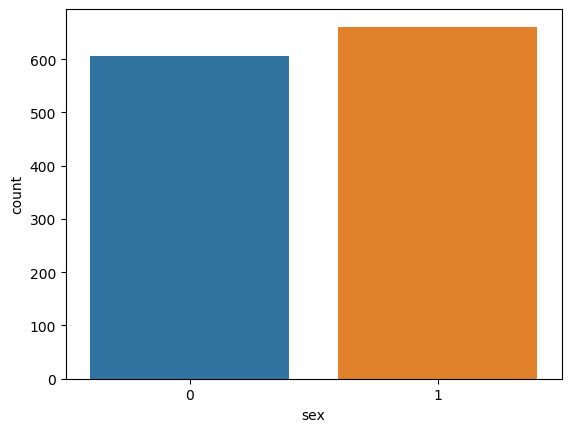

In [168]:
sns.countplot(df_clean['sex']);

**Age** refers to age. Changing to **age**

Age (Years)

In [169]:
df_clean = df_clean.rename(columns = {'Age':'age'})

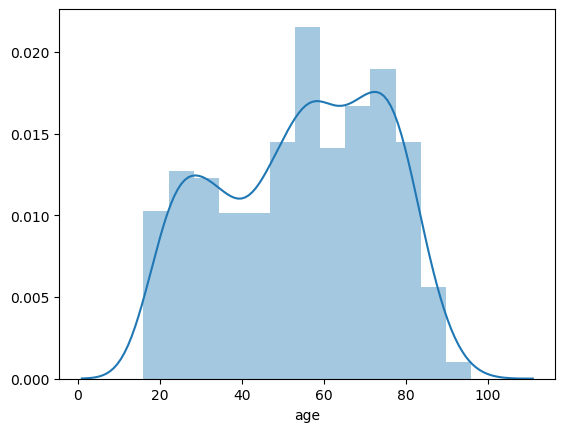

In [170]:
sns.distplot(df_clean['age']);

**Patients number per hour** refers to (maybe) the number in line that this patient was within the hour? I don't fully understand this feature, and the description is not incredibly helpful. Maybe the number of patients who were also seen in this hour? Or an id number for the hour? Changing to **patient_num_hr**

Patients number/hous

Found this:

An independent sample t-test was conducted to compare the number of patient visits per hour in terms of the accuracy and inaccuracy of triage.

So I think number of patients seen in an hour

In [171]:
df_clean = df_clean.rename(columns = {'Patients number per hour':'patient_num_hr'})

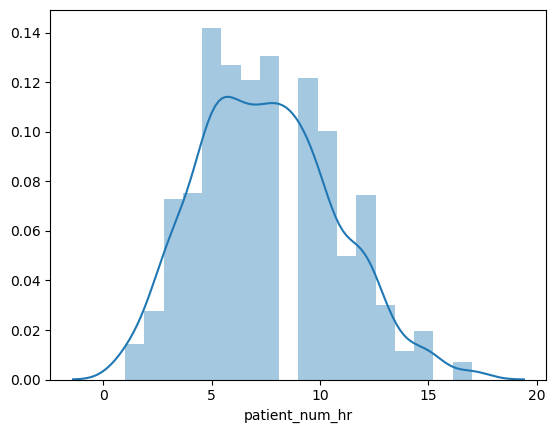

In [172]:
sns.distplot(df_clean['patient_num_hr']);

**Arrival Mode** refers to how the patient got there. This could be:
1: Walking / 2: 119 use / 3: Private car / 4: Private ambulance / 5: Public transfotation (Police ets) /6: Wheelchair / 7: Others 

Changing to **arrival_mode** and replacing categoricals

In [173]:
df_clean = df_clean.rename(columns = {'Arrival mode':'arrival_mode'})
df_clean['arrival_mode'] = df_clean['arrival_mode'].replace({1:'walking', 2:'ambulance', 3:'car', 4:'private_ambulance',
                            5: 'public_transit', 6:'wheelchair', 7:'other', 0:np.nan})

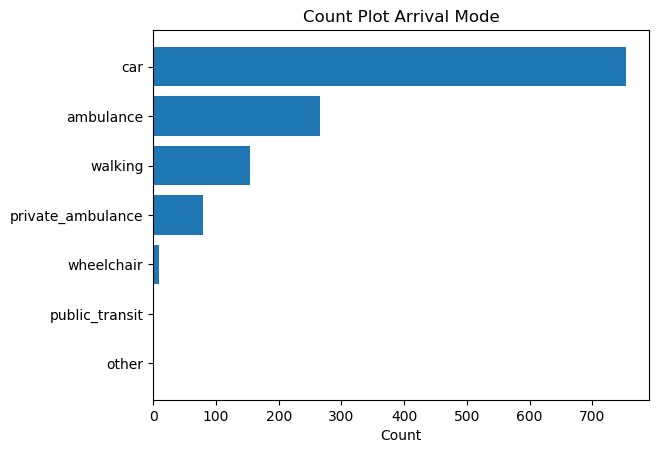

In [174]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_labels = df_clean['arrival_mode'].unique()
y_pos = np.arange(len(y_labels))
x = df_clean['arrival_mode'].value_counts()

ax.barh(y_pos, x, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_title('Count Plot Arrival Mode');

**Injury** refers to whether an injury was present or not. Changing to **injury**

0: Non-injury / 1: Injury

In [175]:
df_clean = df_clean.rename(columns = {'Injury':'injury'})
df_clean['injury'] = df_clean['injury'].replace({1:0, 2:1})

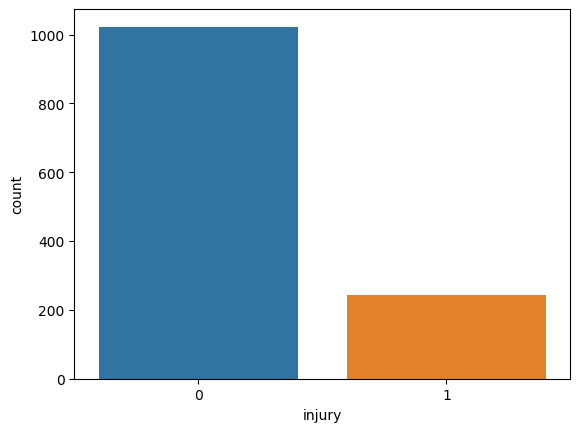

In [176]:
sns.countplot(df_clean['injury'])

**Cheif Complaint** refers to the main complaint. Changing to **complaint**

In [177]:
df_clean = df_clean.rename(columns = {'Chief_complain':'complaint'})

**Mental** refers to mental state. Changint to **mental**

1: Alert / 2: Verval response / 3: Pain response / 4: Unconciousness

Scale goes 1: mild to 4:severe

In [178]:
df_clean = df_clean.rename(columns = {'Mental':'mental'})

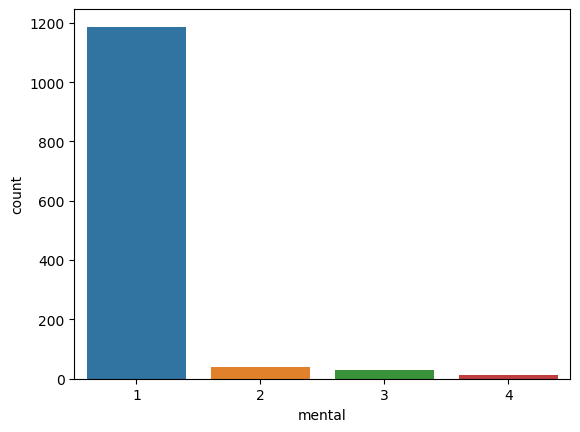

In [179]:
sns.countplot(df_clean['mental'])

**Pain** refers to presence of pain. Change to **pain**

0: Non-pain / 1: Pain

Pain was mislabeled by the feature descriptions. 1 means Pain, because there are only pain scale ratings for 1

In [184]:
df_clean = df_clean.rename(columns = {'Pain':'pain'})

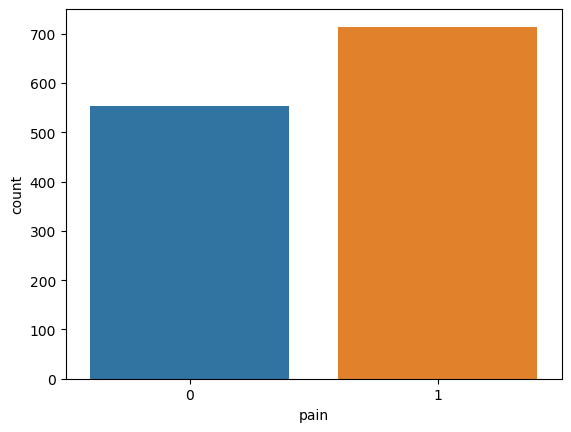

In [185]:
sns.countplot(df_clean['pain'])

**NRS_pain** refers to the pain scale. Change to **pain_scale**

0: none, 9:severe

Numeric rating scales of pain

Contains NaN values

In [186]:
df_clean = df_clean.rename(columns = {'NRS_pain':'pain_scale'})

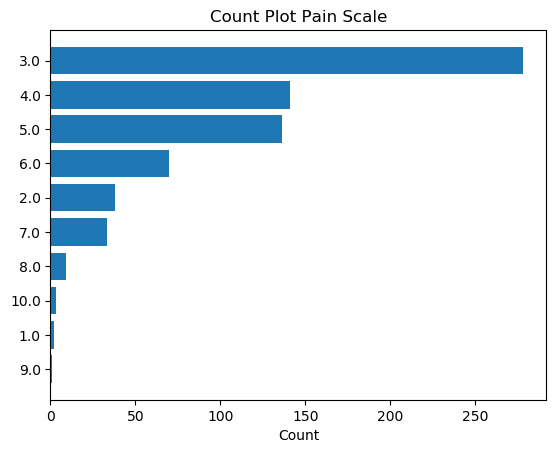

In [187]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_labels = df_clean['pain_scale'].dropna().value_counts().index
y_pos = np.arange(len(y_labels))
x = df_clean['pain_scale'].value_counts()

ax.barh(y_pos, x, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_title('Count Plot Pain Scale');

**SBP** refers to Systolic Blood Pressure 

In [188]:
# Check if strings in SBP
strings = [x for x in df_clean['SBP'] if type(x) is str]

In [189]:
len(strings)

25

In [190]:
#Changing weird '__' to nan
df_clean['SBP'] = df_clean['SBP'].replace({'__':np.nan})

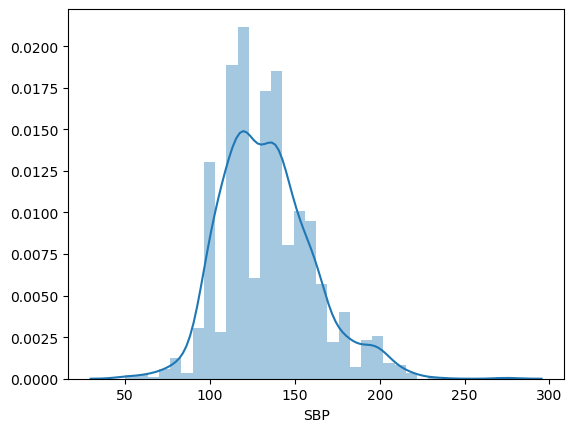

In [191]:
sns.distplot(df_clean['SBP'].dropna());

**DBP** refers to Diastolic blood pressure

In [192]:
# Check if strings in DBP
strings = [x for x in df_clean['DBP'] if type(x) is str]

In [193]:
len(strings)

29

In [194]:
#Changing weird '__' to nan
df_clean['DBP'] = df_clean['DBP'].replace({'__':np.nan})

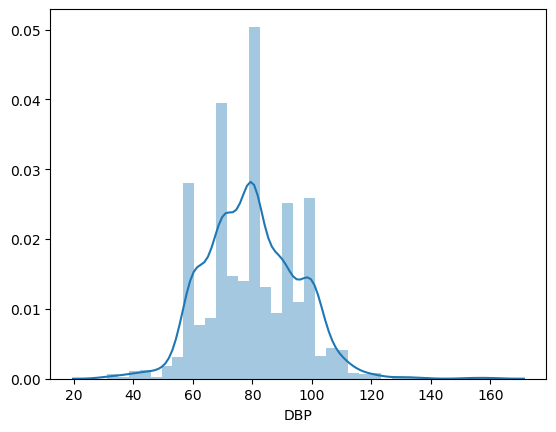

In [195]:
sns.distplot(df_clean['DBP'].dropna());

**HR** refers to heart rate. 

In [196]:
# Check if strings in HR
strings = [x for x in df_clean['HR'] if type(x) is str]

In [197]:
len(strings)

20

In [198]:
#Changing weird '__' to nan
df_clean['HR'] = df_clean['HR'].replace({'__':np.nan})

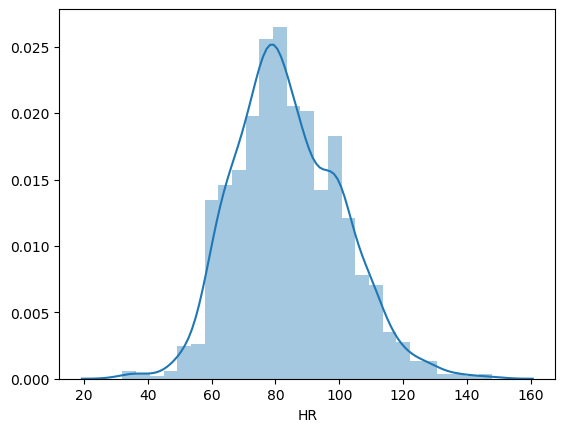

In [199]:
sns.distplot(df_clean['HR'].dropna());

**RR** refers to Respiration rate

In [200]:
# Check if strings in HR
strings = [x for x in df_clean['RR'] if type(x) is str]

In [201]:
len(strings)

22

In [202]:
#Changing weird '__' to nan
df_clean['RR'] = df_clean['RR'].replace({'__':np.nan})

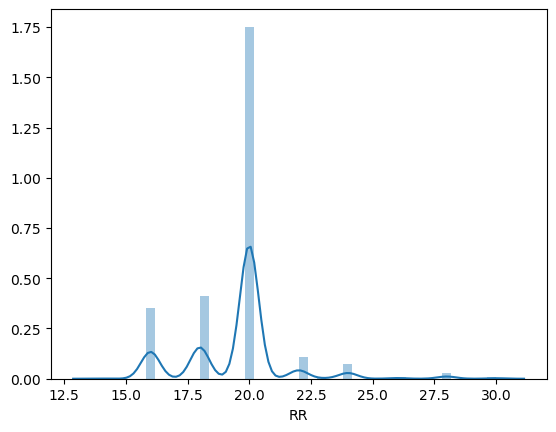

In [203]:
sns.distplot(df_clean['RR'].dropna());

**BT** refers to body temperature

In [204]:
# Check if strings in HR
strings = [x for x in df_clean['BT'] if type(x) is str]

In [205]:
len(strings)

18

In [206]:
#Changing weird '__' to nan
df_clean['BT'] = df_clean['BT'].replace({'__':np.nan})

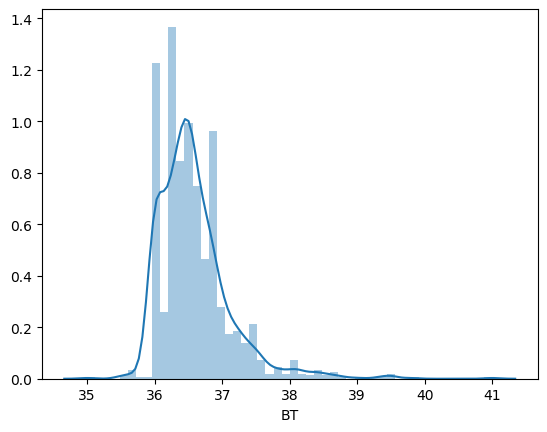

In [207]:
sns.distplot(df_clean['BT'].dropna());

**Saturation** refers to Saturation to use pulse oxmeter

Many nans

In [208]:
df_clean = df_clean.rename(columns = {'Saturation':'saturation'})

In [209]:
# Check if strings in HR
strings = [x for x in df_clean['saturation'] if type(x) is str]

In [210]:
len(strings)

9

In [211]:
#Changing weird '__' to nan
df_clean['saturation'] = df_clean['saturation'].replace({'__':np.nan})

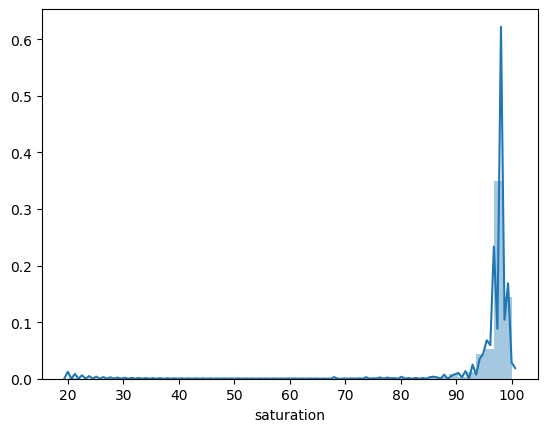

In [212]:
sns.distplot(df_clean['saturation'].dropna())

**KTAS_RN** refers to the triage score an rn nurse gave? I think they're grouping it by expert and novice triage person

KTAS result of nuses in ED

Ok I believe this one is the nurse on the fly rating it, and the KTAS expert is informed by multiple opinions and considered "true"

1: most severe, 5: least 

"Three triage experts, a certified emergency nurse, a KTAS provider and instructor, and a nurse recommended based on excellent emergency department experience and competence determined the true KTAS. Triage accuracy was evaluated by inter-rater agreement between the expert and emergency nurse KTAS scores."

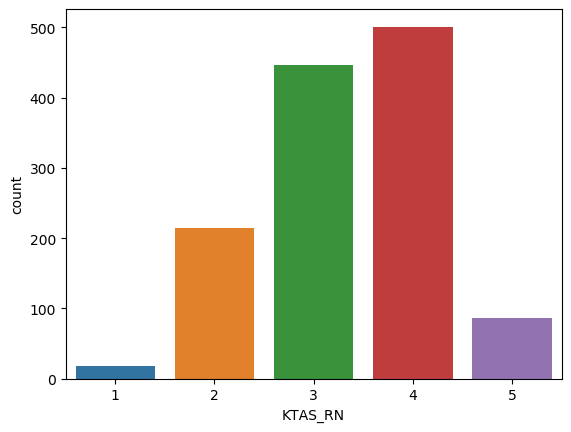

In [213]:
sns.countplot(df_clean['KTAS_RN'])

**Diagnosis in ED** refers to the diagnosis. No description available on feature, but this is what I presume. Changing to **diagnosis**

In [214]:
df_clean = df_clean.rename(columns = {'Diagnosis in ED':'diagnosis'})

**Disposition** refers to the result of triage. Changing to **result**

'1: Discharge / 2: Ward admission / 3: ICU admission / 4: AMA discharge / 5: Transfer / 6: Death / 7: OP fom ED

AMA = against medical advice

OP = Operation?

Ward = general ward = normal room/ not icu

In [215]:
df_clean = df_clean.rename(columns = {'Disposition':'result'})
df_clean['result'] = df_clean['result'].replace({1: 'discharge', 2:'ward', 3:'icu', 4:'ama_discharge',
                                                5:'transfer',6:'death',7:'op'})

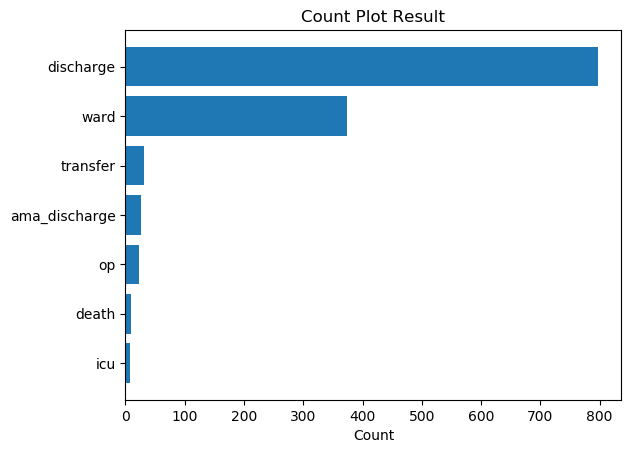

In [216]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_labels = df_clean['result'].dropna().value_counts().index
y_pos = np.arange(len(y_labels))
x = df_clean['result'].value_counts()

ax.barh(y_pos, x, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_title('Count Plot Result');

**KTAS_expert** refers to the rating given by the experts for triage

KTAS result of experts

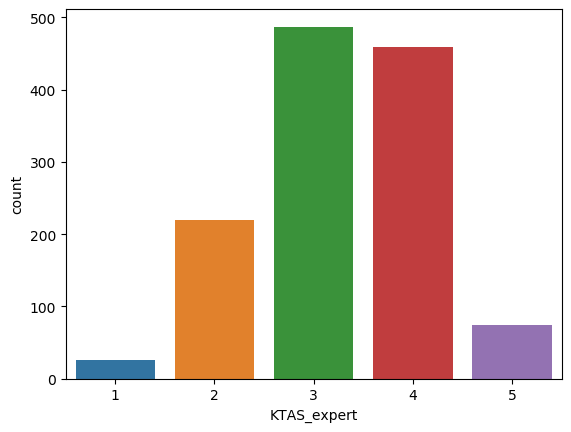

In [217]:
sns.countplot(df_clean['KTAS_expert'])

**Error_group** refers to the experts analysis of why the triage was wrong

"The comments of the experts were analyzed to evaluate the cause of triage error"

1: Vital sign / 2: Physical exam / 3: Psychatric /4: Pain / 5: Mental / 6: Underlying disease / 7: Medical records of other ED / 8: On set / 9: Others

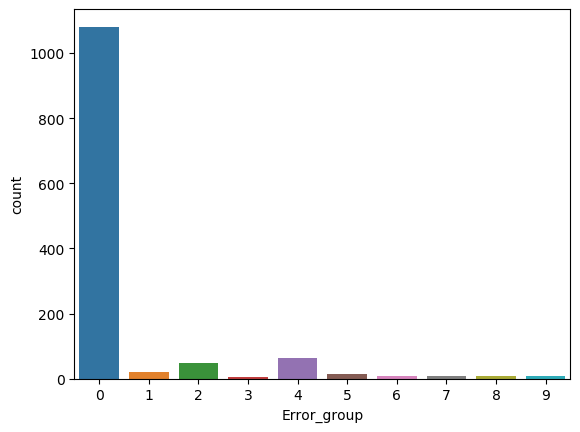

In [218]:
sns.countplot(df_clean['Error_group'])

In [219]:
df_clean = df_clean.rename(columns = {'Error_group':'error_code'})
df_clean['error_code'] = df_clean['error_code'].replace({1: 'vital_sign', 2:'physical_exam', 3:'psychiatric', 
                                                 4:'pain', 5:'mental',6:'underlying',7:'med_record',
                                                8:'on_set', 9:'other', 0:'no_error'})

In [220]:
df_clean['error_code'].unique()

array(['physical_exam', 'pain', 'underlying', 'on_set', 'vital_sign',
       'mental', 'med_record', 'psychiatric', 'other', 'no_error'],
      dtype=object)

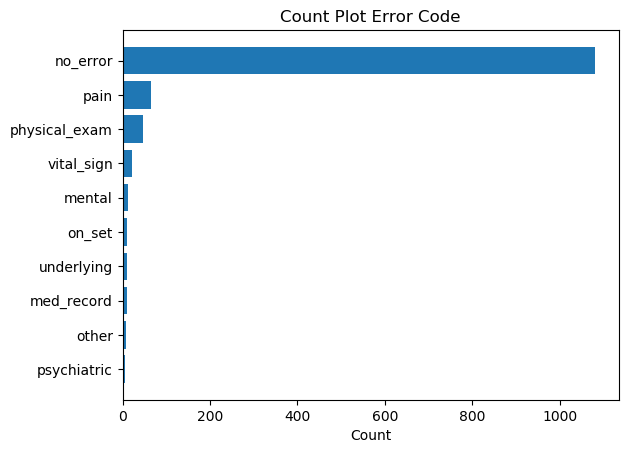

In [221]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_labels = df_clean['error_code'].value_counts().index
y_pos = np.arange(len(y_labels))
x = df_clean['error_code'].value_counts()

ax.barh(y_pos, x, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_title('Count Plot Error Code');

**Length of stay_min** refers to the length of stay in min. Change to **stay_min**

Length of stay (minutes)

Skewed as hell

In [222]:
df_clean = df_clean.rename(columns = {'Length of stay_min':'stay_min'})

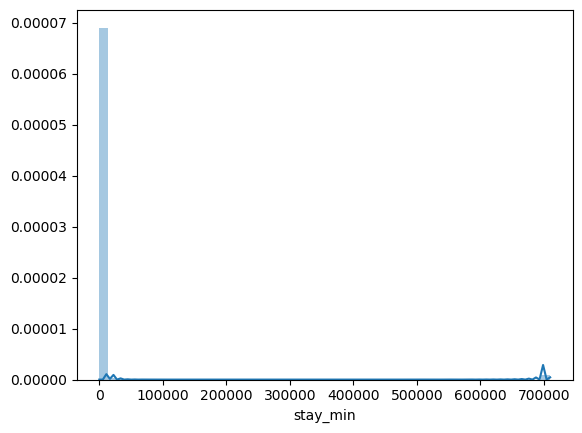

In [223]:
sns.distplot(df_clean['stay_min']);

**KTAS duration_min** refers to I think the length of time it took to assess triage? Unclear

Changing to **KTAS_duration_min**

KTAS duration (minutes)

In [224]:
df_clean = df_clean.rename(columns = {'KTAS duration_min':'KTAS_duration_min'})

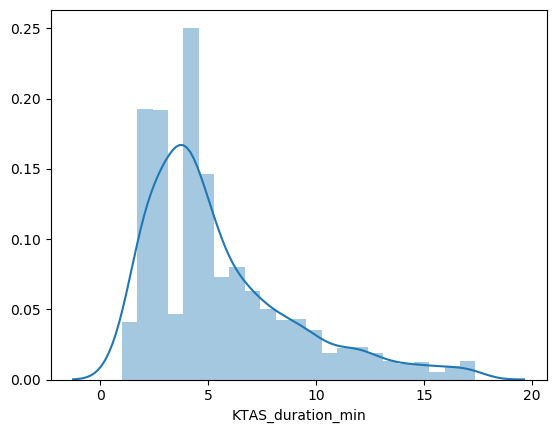

In [225]:
sns.distplot(df_clean['KTAS_duration_min'])

**mistriage** refers to the severity of error in nurse triage compared to expert

0: Correct / 1: Over triage / 2: Under triage

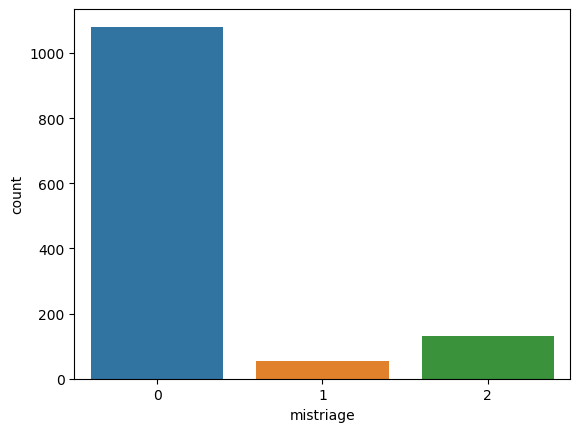

In [226]:
sns.countplot(df_clean['mistriage'])

Leaving the nulls in here for now until I figure out what to do with these

In [227]:
with open('data/df_clean_nulls.pickle', 'wb') as to_write:
    pickle.dump(df_clean, to_write)

## Looking at some initial correlations

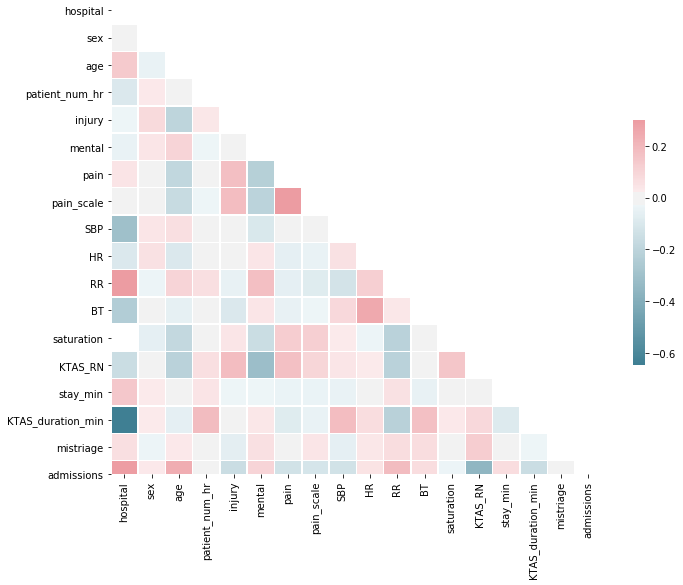

In [5]:
corr = df_clean.drop(['KTAS_expert', 'DBP'], axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Initially identified correlations:

DBP and SBP = diastolic and systolic ---> correlated obviously, maybe could calculate mean arterial pressure? Ask April what to do with this

Body Temp and HR seem correlated

Mental is highly correlated with KTAS. Could be due to skewed data. If you're not looking good you're **really** not looking good. Also below seems to align with this. Visual interpretation is used to move toward 2.

Injury with KTA. Seems true yeah. 

RR and mental a bit



## From ESI site guidelines for triage

![ESI](pics/esi+algo.png)

In [5]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 24 columns):
hospital             1267 non-null int64
sex                  1267 non-null int64
age                  1267 non-null int64
patient_num_hr       1267 non-null int64
arrival_mode         1267 non-null object
injury               1267 non-null int64
complaint            1267 non-null object
mental               1267 non-null int64
pain                 1267 non-null int64
pain_scale           711 non-null float64
SBP                  1242 non-null float64
DBP                  1238 non-null float64
HR                   1247 non-null float64
RR                   1245 non-null float64
BT                   1249 non-null float64
saturation           570 non-null float64
KTAS_RN              1267 non-null int64
diagnosis            1265 non-null object
result               1267 non-null object
KTAS_expert          1267 non-null int64
error_code           1267 non-null object
stay_min       

I think one thing that can be done for saturation is to just assume normal sat for those without values

In [4]:
df_clean.groupby('saturation').mean()

,hospital,sex,age,patient_num_hr,injury,mental,pain,pain_scale,SBP,DBP,HR,RR,BT,KTAS_RN,KTAS_expert,stay_min,KTAS_duration_min,mistriage
saturation,,,,,,,,,,,,,,,,,,
20.0,1.0,1.000000,77.000000,7.000000,0.000000,1.000000,0.0,NaN,130.000000,80.000000,56.000000,20.000000,36.200000,3.000000,3.000000,8258.000000,1.000000,0.000000
68.0,1.0,1.000000,82.000000,6.000000,0.000000,1.000000,0.0,NaN,150.000000,100.000000,116.000000,26.000000,37.000000,2.000000,1.000000,9270.000000,2.000000,2.000000
74.0,1.0,0.000000,79.000000,8.000000,0.000000,1.000000,0.0,NaN,130.000000,80.000000,60.000000,24.000000,36.400000,2.000000,2.000000,9378.000000,5.000000,0.000000
76.0,1.0,1.000000,80.000000,10.000000,0.000000,1.000000,0.0,3.000000,120.000000,80.000000,118.000000,20.000000,36.000000,2.000000,2.000000,9984.000000,4.000000,0.000000
78.0,1.0,0.000000,70.000000,8.000000,0.000000,2.000000,0.0,3.000000,NaN,NaN,96.000000,22.000000,36.300000,2.000000,1.000000,593.000000,2.000000,2.000000
80.0,1.0,0.000000,54.000000,3.000000,0.000000,1.000000,0.0,NaN,180.000000,100.000000,108.000000,24.000000,36.600000,3.000000,3.000000,10895.000000,4.000000,0.000000
85.0,1.0,1.000000,22.000000,10.000000,0.000000,3.000000,0.0,NaN,100.000000,60.000000,98.000000,24.000000,37.600000,2.000000,2.000000,8703.000000,4.000000,0.000000
86.0,1.0,0.500000,45.000000,5.500000,0.000000,3.500000,0.0,NaN,70.000000,50.000000,72.000000,20.000000,36.250000,1.500000,1.500000,455.000000,5.000000,0.000000
88.0,1.0,0.500000,80.500000,7.000000,0.000000,1.000000,0.0,NaN,155.000000,95.000000,93.000000,23.000000,36.400000,2.500000,2.000000,349727.000000,3.000000,1.000000


Looks like all the saturation values are from hospital 1...checking this

In [5]:
df_clean.groupby('hospital').count()

,sex,age,patient_num_hr,arrival_mode,injury,complaint,mental,pain,pain_scale,SBP,...,BT,saturation,KTAS_RN,diagnosis,result,KTAS_expert,error_code,stay_min,KTAS_duration_min,mistriage
hospital,,,,,,,,,,,,,,,,,,,,,
0,688,688,688,688,688,688,688,688,370,670,...,674,0,688,688,688,688,688,688,688,688
1,579,579,579,579,579,579,579,579,341,572,...,575,570,579,577,579,579,579,579,579,579


Yep. All saturation values are from hospital 1. This means that assuming normal values for hospital 0 won't work. I'm going to remove saturation as a feature when using all the data and try a model with just hospital 1 to see if it's a good predictor.

Some vitals are missing. My assumption is that these are for cat 1 triage, because there isn't time.

<img src="pics/9842-blood-pressure-readings-explained-1296x1645-body.20181002181105178.jpg" width="350">

## Let's Deal with the Nulls

In [259]:
with open('data/df_clean_nulls.pickle', 'rb') as read_file:
    df_clean = pickle.load(read_file)

In [261]:
df_clean['BT'].median()

36.5

In [262]:
# Filling BT with median BT (36.5)
df_clean['BT'] = df_clean['BT'].fillna(36.5)

In [263]:
df_clean['RR'].median()

20.0

In [264]:
# Filling RR with median 20 (a little high) 
df_clean['RR'] = df_clean['RR'].fillna(20)

In [265]:
df_clean.loc[(df_clean['hospital'] == 1) & (df_clean['KTAS_RN'] >=4), 'saturation'].mean()

97.77731092436974

In [266]:
df_clean.loc[(df_clean['hospital'] == 1) & (df_clean['KTAS_RN'] <4), 'saturation'].mean()

96.48493975903614

In [267]:
# Filling saturation for hospital 1 KTAS > 4 with mean
df_clean.loc[(df_clean['saturation'].isnull()) & \
                                                   (df_clean['hospital'] == 1) & (df_clean['KTAS_RN'] >= 4),'saturation'] = [98 for x in df_clean.loc[(df_clean['saturation'].isnull()) & \
                                                   (df_clean['hospital'] == 1) & (df_clean['KTAS_RN'] >= 4),'saturation']]

In [268]:
# Filling saturation for hospital 1 KTAS < 4 with mean
df_clean.loc[(df_clean['saturation'].isnull()) & \
                                                   (df_clean['hospital'] == 1) & (df_clean['KTAS_RN'] < 4),'saturation'] = [96.5 for x in df_clean.loc[(df_clean['saturation'].isnull()) & \
                                                   (df_clean['hospital'] == 1) & (df_clean['KTAS_RN'] < 4),'saturation']]

In [269]:
df_clean['HR'].mean()

83.96311146752205

In [270]:
df_clean['HR'].median()

82.0

In [271]:
# Filling HR with mean
df_clean['HR'] = df_clean['HR'].fillna(np.mean(df_clean['HR']))

In [272]:
df_clean.loc[(df_clean['SBP'] <=70), ['SBP', 'DBP']]

,SBP,DBP
122,50.0,33.0
123,50.0,33.0
133,65.0,45.0
153,70.0,NaN
968,60.0,NaN
971,70.0,NaN
1054,60.0,NaN
1131,70.0,40.0
1205,70.0,40.0


In [273]:
df_clean.loc[(df_clean['SBP'] <= 70), 'DBP'].mean()

38.2

In [274]:
#Filling DBP where only SBP is present. Median of this group's SBP is considerably lower. Using the median DBP of SBP's less than 70
df_clean.loc[(df_clean['DBP'].isnull()) & (df_clean['SBP'].notnull()), 'DBP'] = [38.2 for x in df_clean.loc[(df_clean['DBP'].isnull()) & \
                                                   (df_clean['SBP'].notnull()), 'SBP']]

In [275]:
df_clean['DBP'].median()

80.0

In [276]:
df_clean['SBP'].median()

130.0

In [277]:
#Filling the rest of DBP and SBP with median
df_clean['DBP'] = df_clean['DBP'].fillna(80)
df_clean['SBP'] = df_clean['SBP'].fillna(130)

In [278]:
df_clean['pain_scale'].unique()

array([ 2.,  3.,  4.,  5.,  6.,  8.,  9., nan,  1.,  7., 10.])

In [279]:
#Filling pain_scale nan with 0 if no pain present
df_clean['pain_scale'] = df_clean['pain_scale'].fillna(0)

In [280]:
df_clean.describe()

,hospital,sex,age,patient_num_hr,injury,mental,pain,pain_scale,SBP,DBP,HR,RR,BT,saturation,KTAS_RN,KTAS_expert,stay_min,KTAS_duration_min,mistriage
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,579.00000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000
mean,0.456985,0.521705,54.423836,7.519337,0.192581,1.105762,0.563536,2.303078,133.576953,79.653354,83.963111,19.515391,36.579479,97.02677,3.335438,3.265983,11016.102605,5.497466,0.250197
std,0.498343,0.499726,19.725033,3.160563,0.394482,0.447768,0.496143,2.298021,27.009758,15.160456,16.512102,2.000089,0.541899,4.31759,0.885391,0.885803,80446.092065,3.459470,0.628250
min,0.000000,0.000000,16.000000,1.000000,0.000000,1.000000,0.000000,0.000000,50.000000,31.000000,32.000000,14.000000,35.000000,20.00000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,37.000000,5.000000,0.000000,1.000000,0.000000,0.000000,115.000000,70.000000,72.000000,18.000000,36.200000,97.00000,3.000000,3.000000,133.000000,3.000000,0.000000
50%,0.000000,1.000000,57.000000,7.000000,0.000000,1.000000,1.000000,3.000000,130.000000,80.000000,82.000000,20.000000,36.500000,98.00000,3.000000,3.000000,274.000000,4.280000,0.000000
75%,1.000000,1.000000,71.000000,10.000000,0.000000,1.000000,1.000000,4.000000,150.000000,90.000000,96.000000,20.000000,36.800000,98.00000,4.000000,4.000000,606.500000,7.000000,0.000000
max,1.000000,1.000000,96.000000,17.000000,1.000000,4.000000,1.000000,10.000000,275.000000,160.000000,148.000000,30.000000,41.000000,100.00000,5.000000,5.000000,709510.000000,17.370000,2.000000


## Adding/Formatting Features

In [283]:
df_clean['result'].unique()

array(['discharge', 'ward', 'transfer', 'op', 'death', 'icu',
       'ama_discharge'], dtype=object)

In [284]:
# Group results column based on whether the patient is admitted to the hospital or not
df_clean['admissions'] = df_clean['result'].replace({'discharge':0, 'ward':1, 'transfer':1, 'op':1, 'death':0,
                                              'icu':1, 'ama_discharge':0})

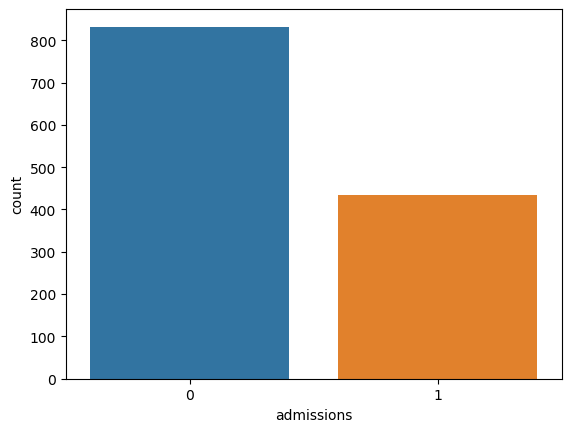

In [285]:
sns.countplot(df_clean['admissions'])

In [286]:
with open('data/df_clean_few_nulls.pickle', 'wb') as to_write:
    pickle.dump(df_clean, to_write)

In [2]:
import pickle

In [3]:
with open('data/df_clean_few_nulls.pickle', 'rb') as read_file:
    df_clean = pickle.load(read_file)

In [8]:
df_clean.to_csv('data/clean.csv')

In [4]:
df_clean.head()

,hospital,sex,age,patient_num_hr,arrival_mode,injury,complaint,mental,pain,pain_scale,...,saturation,KTAS_RN,diagnosis,result,KTAS_expert,error_code,stay_min,KTAS_duration_min,mistriage,admissions
0,1,1,71,3,car,1,right ocular pain,1,1,2.0,...,100.0,2,Corneal abrasion,discharge,4,physical_exam,86,5.00,1,0
1,0,0,56,12,car,1,right forearm burn,1,1,2.0,...,NaN,4,"Burn of hand, firts degree dorsum",discharge,5,pain,64,3.95,1,0
2,1,0,68,8,ambulance,1,"arm pain, Lt",1,1,2.0,...,98.0,4,"Fracture of surgical neck of humerus, closed",ward,5,pain,862,1.00,1,1
3,0,1,71,8,walking,0,ascites tapping,1,1,3.0,...,NaN,4,Alcoholic liver cirrhosis with ascites,discharge,5,underlying,108,9.83,1,0
4,0,1,58,4,car,0,"distension, abd",1,1,3.0,...,NaN,4,Ascites,discharge,5,on_set,109,6.60,1,0
